# Zillow 2017 Predictions

### Project Goals  
- Discover drivers of Single Family home values for Zillow in 2017 from Los Angeles county and Nevada county in California.
- Use drivers to develop a machine learning model that helps predicts home value
- This information could be used for furture years in helping Zillow achieve max profit


In [1]:
# Data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Statistical/mathmatical imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from math import sqrt
# ML imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
# Premade functions
import acquire as a
import wrangle as w
import explore as e
import model as m
#Removes big scary warnings
import warnings
warnings.filterwarnings('ignore')
seed = 42

# Acquire

- Data aquired from SQL zillow database  
- It contained 52441 rows and 6 columns before cleaning  
- Each row represents a house in 2017 
- Each column represents a feature associated with the house  

In [2]:
# Use acquire function to import messy data
df = a.get_zillow_data()
# Lets take a peak
df.head(1)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,lotsizesquarefeet,yearbuilt
0,5.0,4.0,2148.0,165392.0,10408.0,1976.0


# Prepare

- Renamed colums to read easier on the eyes  
- Checked for nulls in the data and dropped said nulls  
- Checked that column data types were appropriate and had to change as necessary  
- Got rid of major outliers that skewed the data 
- Split data into train, validate and test, stratifying on 'tax_value'  

In [3]:
# Use prepare function to clean data 
df = w.prep_zillow(df)
# Quick peak into the cleaned data
df.head(1)

,bedrooms,bathrooms,house_sqft,tax_value,lot_size_sqft,year_built
0,5,4.0,2148,165392,10408,1976


# Data Dictionary

This will help with any questions or information on this dataset

| Feature | Definition |
|:--------|:-----------|
|bedroomcnt|Specifies the number of bedrooms in the home|
|bathroomcnt|Specifies the number of bathrooms in the home|
|calculatedfinishedsquarefeet|Specifies the total finished square footage of the home|
|taxvaluedollarcnt|The total tax assessed value of the parcel|
|lotsizesquarefeet|Specifies total square footage of lot the home sits on|
|yearbuilt|Year that the home was built|


# Split data into train/validate/test sample dataframes

- 20% test, 80% train_validate  
- Then of the 80% train_validate: 30% validate, 70% train    

In [4]:
# splitting data into train, validate, and test
train, validate, test = w.split_zillow(df)
# lets show some train data
train.head(3)

,bedrooms,bathrooms,house_sqft,tax_value,lot_size_sqft,year_built
31949,3,2.0,1404,176411,7704,1957
51617,3,2.0,1456,72444,5369,1954
42382,3,1.0,1055,64630,6550,1953


# Exploration

- Here we will be asking some questions of our data 
- We will then support these questions with visuals and statistical tests


### Are square footage and home value correlated?

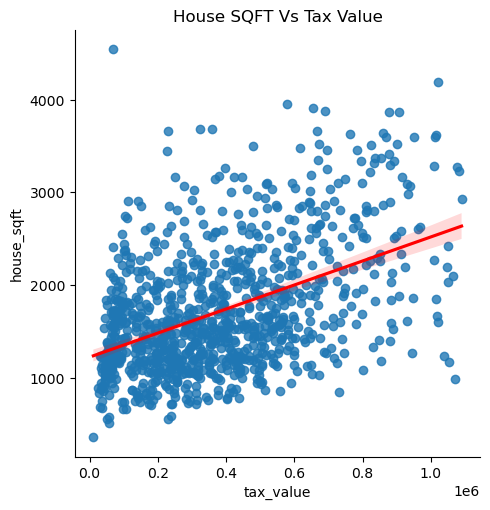

In [5]:
# plot question 1 from premade function
e.plot_q1(train)

#### My takeaway:  
<br>
For this visual, there is some data that looks correlated. Perhaps we can see if there is something to get out of a statistical test. 

$H_o$ (Null Hypothesis): is that there is no linear correlation between house sqft and tax value.  
$H_a$ (Alternative Hypothesis): There is a linear correlation between house sqft and tax value.  

In [6]:
# function for stats test
e.q1_stats_test(train)

We reject the null hypothesis, there is correlation
correlation: 0.4623332209166028
p:           0.0


### Does the number of bathrooms affect tax value?

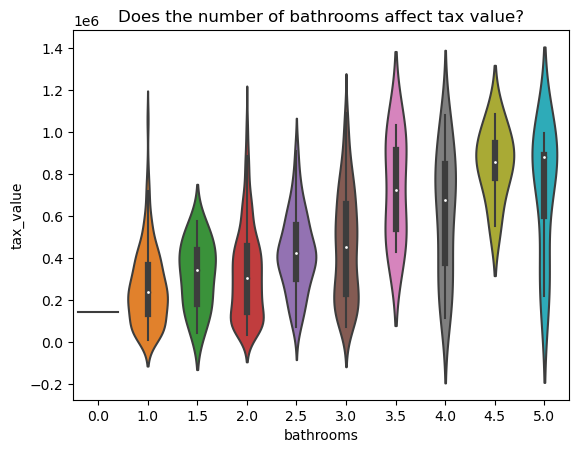

In [40]:
# function for visual 2
e.plot_q2(train)

#### My takeaway:  
<br>

For this visual there does seem to be a slight trend of more bathrooms and more tax value. Lets do an independent t-test to confirm.

$H_o$ (Null Hypothesis): There is no linear correlation between bathrooms and tax value

$H_a$ (Alternative Hypothesis): There is a linear correlation between bathrooms and tax value

In [8]:
# funtion for stats test
e.q2_stats_test(train)

We reject the null hypothesis, there is correlation
correlation: 0.22498899860871005
p:           1.547034361660423e-268


### Does lot size affect tax value?

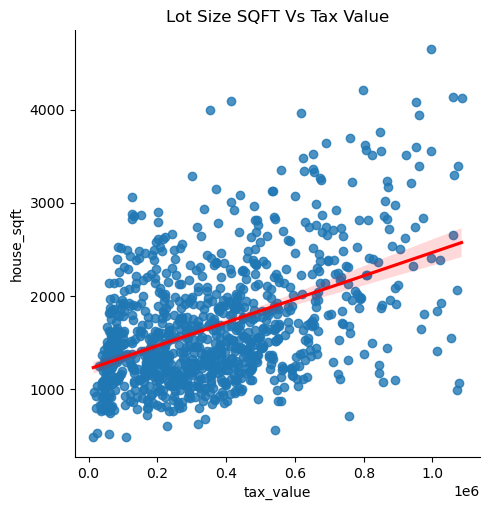

In [9]:
# function for visual 3
e.plot_q3(train)

#### My takeaway:     
<br>
- For this question there appears to be a trend with square footage and tax value.

### Does number of bedrooms have an affect on tax value?

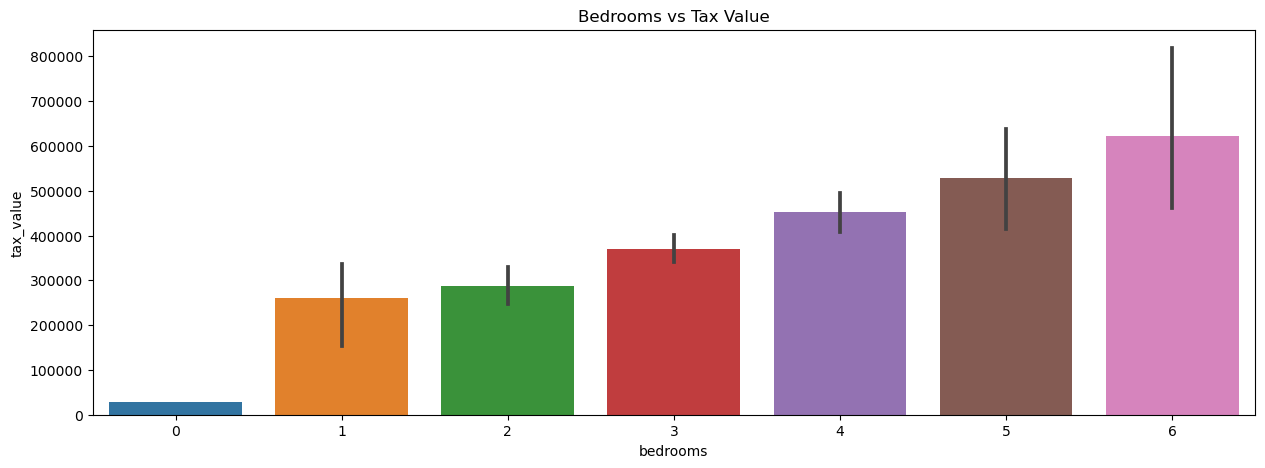

In [45]:
# function for visual 4
e.plot_q4(train)

#### My takeaway:    
<br>

For this question, the visual speaks for itself, but lets confirm with a test. 
<br>

$H_o$ (Null Hypothesis): There is no linear correlation between bedrooms and tax value

$H_a$ (Alternative Hypothesis): There is linear correlation between bedrooms and tax value

In [11]:
e.q4_stats_test(train)

We reject the null hypothesis, there is correlation
correlation: 0.22498899860871005
p:           1.547034361660423e-268


# Exploration Summary
<br>

- Home square footage has a positive correlation to tax value
- Number of bedrooms drives up tax value
- Number of bathrooms also drives up tax value
<br>

We are moving forward to include these drivers in our model:
- square feet
- bedrooms
- bathrooms


# Modeling
<br>

- I ran LinearRegression (OLS), LassoLars, TweedieRegressor (GLM), and Polynomial Regression algorithms to see what fit the data best.

- The basline accuracy is calculated by finding the median tax value

In [12]:
X_train, y_train, X_validate, y_validate, X_test, y_test = m.x_y_tvt(train, validate, 
                                                                     test, 'tax_value')

In [13]:
columns_to_scale = ['bedrooms', 'bathrooms', 'house_sqft','lot_size_sqft']
X_train_scaled, X_validate_scaled, X_test_scaled = w.scale_data(train, validate, 
                                                                test, columns_to_scale)

In [33]:
# generate baseline median and baseline
preds_df = m.create_preds_df(y_train)

### Linear Regression (OLS)

In [15]:
#function for Linear Regresssion
preds_df = m.lin_regression(X_train, y_train, preds_df)


### LassoLars

In [16]:
#function for LassoLars
preds_df = m.lasso_lars(X_train, y_train, preds_df)

### TweedieRegressor (GLM)

In [17]:
#function for TweedieRegressor
preds_df = m.glm_model(X_train, y_train, preds_df, 0)

### Polynomial Regression

In [18]:
#function for Polynomial Regression
X_polynomial = m.poly_subset(X_train, y_train, 2)

In [19]:
#function for polynommial model 
preds_df = m.poly_model(X_train, y_train, preds_df, LinearRegression())

In [20]:
# function for all rmse values
m.get_rmses(preds_df)

,model,rmse
0,linear,211175.609161
1,lasso,211175.615869
2,tweedie_norm,211936.794640
3,linear_poly,211175.609161


### Test Model  
<br>

- I am choosing the LinearRegression model for the test data
- I will now run my model on the test data to gauge how it will perform on unseen data.

In [21]:
# code for number to beat
sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline_median']))

243892.75312614496

In [22]:
# code for test model
final_preds = m.create_preds_df(y_test)

In [23]:
# test on test
final_preds = m.lasso_lars(X_test, y_test, final_preds)

In [24]:
# final result
sqrt(mean_squared_error(final_preds['actual'], final_preds['lasso_preds']))

210695.3141271506

In [25]:
#creating the dataframe
final_preds = m.create_preds_df(y_test)

In [26]:
#function for lasso-lars model on test data
final_preds = m.lasso_lars(X_test, y_test, final_preds)

In [27]:
# 
test_rmse = sqrt(mean_squared_error(final_preds['actual'], final_preds['lasso_preds']))
baseline_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline_median']))

In [37]:
#creating a DataFrame for the test results compared to baseline
data = {'model': ['lasso_lars_model', 'baseline_model'],
        'results': [test_rmse, baseline_rmse]}
final_stats = pd.DataFrame(data, index=['test_results', 'baseline'])

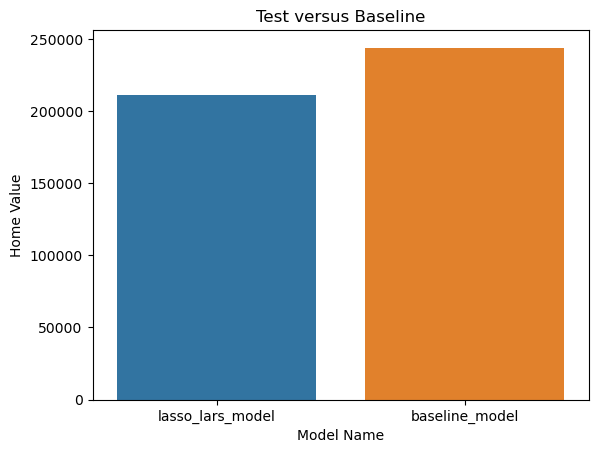

In [29]:
# visual wrap up
m.test_plot(final_stats)

### Modeling Wrap
<br>
- Test score outperforms the baseline and I would reccomend this model for production

# Conclusion
<br>

### Summary
- Square feet, bedrooms, and bathrooms are all drivers to tax value    
- Higher bedroom count, higher bathroom count, and higher square footage amount all contribute to a higher tax value of a home
- Bedrooms and bathrooms had a strong correlation with each other

### Recommendations
<br>

- Push the homes with above average bedroom count and bathroom count as they are big drivers of home value
- Push homes with above average home square footage as they are also drivers of home value
- Perhaps more information about exterior and interior finishes to help with determining value

### Next Steps
<br>

- If provided more time to work on this project I would add more features and do some feature engineering.